In [65]:
%load_ext autoreload
%autoreload 2

In [344]:
import chromadb
import json
import pandas as pd
from chromadb.utils.data_loaders import ImageLoader
from tools.embedding_tools import SigLIPEmbedder
from tools.weaving_tools import plot_query_results, get_query_results
import scipy.spatial as sp
import seaborn as sns
import numpy as np
import random
sns.set()

In [323]:
def plot_record_pair(record_pair):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
    
    for i in range(2):
        record = collection_df[collection_df.record_id==record_pair[i]]
        img_path = record.img_path.values[0]
        description = soft_wrap_text(record.description.values[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(description, fontsize = 18)
        axes[i].axis('off')
         
    plt.show()

In [69]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="ce_comms_db")

data_loader = ImageLoader()

collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

collection_df = pd.read_csv('data/communications_data.csv')
collection_df.shape[0], collection_db.count()

# Retrieval Annotation

In [157]:
from tools.annotation_tools import plot_by_record
import requests
import time
from pathlib import Path
from io import BytesIO

In [154]:
out_path = Path('annotations')
out_path.mkdir(exist_ok=True)

In [202]:
plt.ioff() # turn off default inline plotting

# filters = {
#     "$and": [
#         {
#             "input_modality": {
#                 "$eq": "text"
#             }
#         },
#         {
#             "collection": {
#                 "$eq" : "smg"
#             }
#         }
#     ]
# }

modality = "text"
filters = {"input_modality": modality}
top_n = 20
annotator = 'KB'

In [203]:
query = 'telephone with dial'
results = collection_db.query(query_texts=[query],where=filters, n_results=top_n)

In [198]:
query = 'https://i.ebayimg.com/images/g/4SUAAOSwOelisbt4/s-l1600.jpg'
response = requests.get(query)
img = Image.open(BytesIO(response.content))
results = collection_db.query(query_images=[img],where=filters, n_results=top_n)

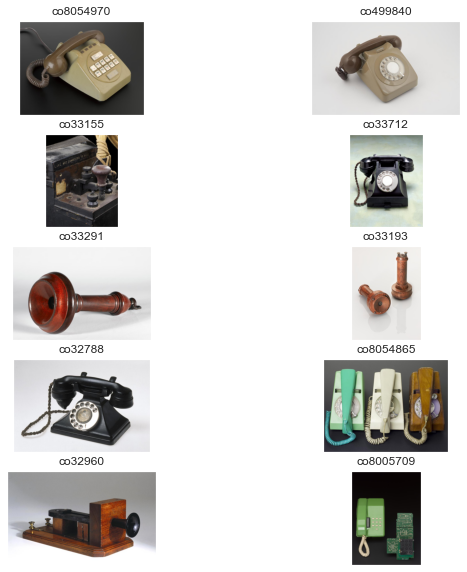

17

In [204]:
query_df = plot_query_results(results, collection_df)
inputs = list(query_df.to_records()); len(inputs)

In [163]:
labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['relevant', 'not relevant'], allow_freetext=False,
        display_function=plot_by_record)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(inputs.pop(0))
    except IndexError:
        print("Finished.")
        
widget.on_submit(store_annotations)
widget.display(inputs.pop(0))
widget

ClassLabeller(children=(Box(children=(Output(layout=Layout(margin='auto', min_height='50px')),), layout=Layout…

Finished.


In [169]:
query_df['labels'] = labels[:top_n]
query_df['query'] = query
query_df['modality'] = modality
query_df.to_csv(out_path / f'{annotator}_{time.time()}.csv')

# Link Annotation

In [343]:
annotator = 'KB'
num_annotations = 10
to_annotate = edges[:num_annotations]
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'image', 'image'
percentile = 99.5
randomize = True

In [336]:
filter_smg = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality1
            }
        },
        {
            "collection": {
                "$eq" : coll1
            }
        }
    ]
}


smg_data = collection_db.get(
                where=filter_smg,
                include=['embeddings','metadatas']

                    )

filter_nms = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality2
            }
        },
        {
            "collection": {
                "$eq" : coll2
            }
        }
    ]
}

nms_data = collection_db.get(
                where=filter_nms,
                include=['embeddings','metadatas']
            )

<Axes: >

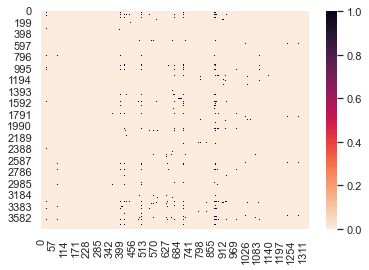

In [337]:
smg_ids = smg_data['ids']
nms_ids = nms_data['ids']

smg_rids = [record['record_id'] for record in smg_data['metadatas']]
nms_rids = [record['record_id'] for record in nms_data['metadatas']]

smg_emb = np.matrix(smg_data['embeddings'])
nms_emb = np.matrix(nms_data['embeddings'])
image_similarities = 1 - sp.distance.cdist(smg_emb,nms_emb, 'cosine')

threshold = np.percentile(image_similarities.reshape(-1), percentile) ; threshold

image_similarities[image_similarities >= threshold] = 1
image_similarities[image_similarities < threshold] = 0
sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

In [338]:
#image_similarities.sum(axis=1).sum()/(image_similarities.shape[0]*image_similarities.shape[1])

In [339]:
smg_node_ids = list(np.where(image_similarities.sum(axis=1) > 0)[0])
nms_node_ids = list(np.where(image_similarities.sum(axis=0) > 0)[0])

smg_mapping = {i:j for i,j in zip(range(len(smg_data['embeddings'])),smg_rids)}
nms_mapping = {i:j for i,j in zip(range(len(nms_data['embeddings'])),nms_rids)}

In [340]:
edges = [(smg_mapping[i],nms_mapping[j]) for i,j in zip(*np.where(image_similarities > 0))]

In [341]:
print(len(edges))

25313


In [345]:
if randomize:
    random.shuffle(edges)
img_pairs = edges[:num_annotations]

In [346]:
labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['link', 'no link'], allow_freetext=True,
        display_function=plot_record_pair)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(img_pairs.pop(0))
    except IndexError:
        print("Finished.")
widget.on_submit(store_annotations)
widget.display(img_pairs.pop(0))
widget


ClassLabeller(children=(Box(children=(Output(layout=Layout(margin='auto', min_height='50px')),), layout=Layout…

Finished.


In [369]:
annotations_df = pd.DataFrame(to_annotate, columns=['coll1','coll2'])
annotations_df['labels'] = labels[:num_annotations]

In [370]:
for varname, var in [('coll1_name',coll1), ('coll2_name',coll2), ('modality1',modality1), ('modality2',modality2)]:
    annotations_df[varname] = var

In [371]:
annotations_df

,coll1,coll2,labels,coll1_name,coll2_name,modality1,modality2
0,co8405136,T.1963.47,no link,smg,nms,image,image
1,co8405136,T.1967.51,link,smg,nms,image,image
2,co8405136,T.1967.52,link,smg,nms,image,image
3,co8405136,T.1967.150,link,smg,nms,image,image
4,co8405136,T.1970.41,no link,smg,nms,image,image
5,co8405136,T.1971.50,no link,smg,nms,image,image
6,co8405136,T.1971.74,link,smg,nms,image,image
7,co8405136,T.1972.X.6,link,smg,nms,image,image
8,co8405136,T.1975.67,link,smg,nms,image,image
9,co8405136,T.1976.114,link,smg,nms,image,image


In [372]:
annotations_df.to_csv(out_path / f'{annotator}_{time.time()}')